# Optimization WFA - Linear Regression

## Linear Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

In [5]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [6]:
XAUUSD = load_data()

In [7]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [8]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


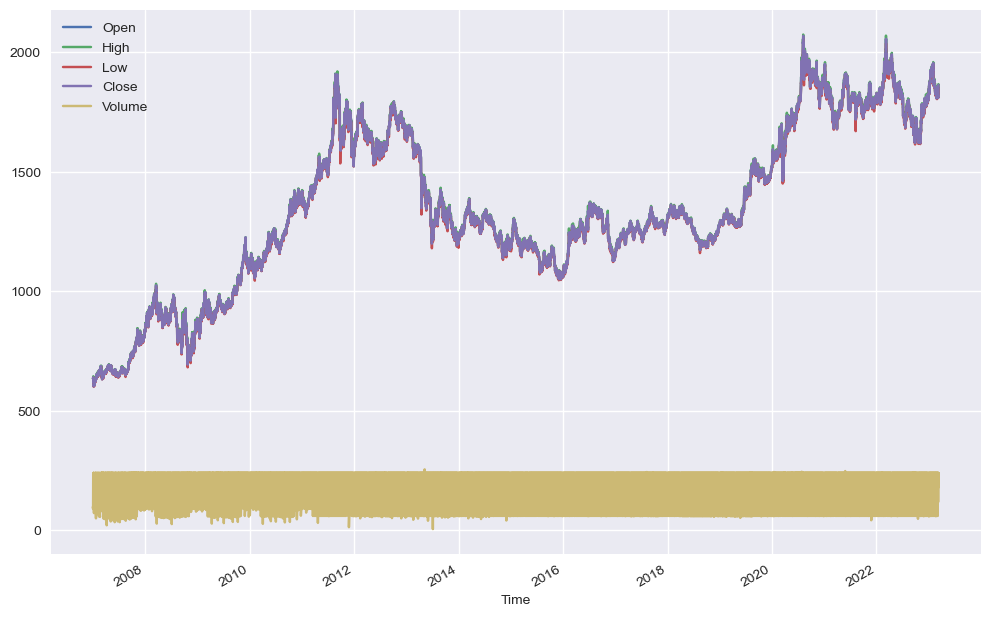

In [9]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [10]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [11]:
mainFolder = 'Machine_Learning'
strategy = Linear_Regression
strategyName = 'Linear_Regression'
account_size = 1000
folder_ML_Strategy = 'Linear Regression'
subFolder = 'Optimization'

In [12]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [13]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size , account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=1):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []
        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size + 1:i + 1]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols], rolling_window_data['returns_signal'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()


    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy, cash = account_size  , margin= 1/100)
        result = backtest.run()
        return result

    

    def Run(self) :
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [35]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [36]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [37]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   94.980159
Equity Final [$]                     4673.764
Equity Peak [$]                      4769.424
Return [%]                           367.3764
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                    8.014818
Volatility (Ann.) [%]               10.306438
Sharpe Ratio                         0.777652
Sortino Ratio                        1.237137
Calmar Ratio                         0.285396
Max. Drawdown [%]                  -28.083164
Avg. Drawdown [%]                   -1.564507
Max. Drawdown Duration      673 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                 1227
Win Rate [%]                        54.604727
Best Trade [%]                      31.512151
Worst Trade [%]                     -9.694351
Avg. Trade [%]                    

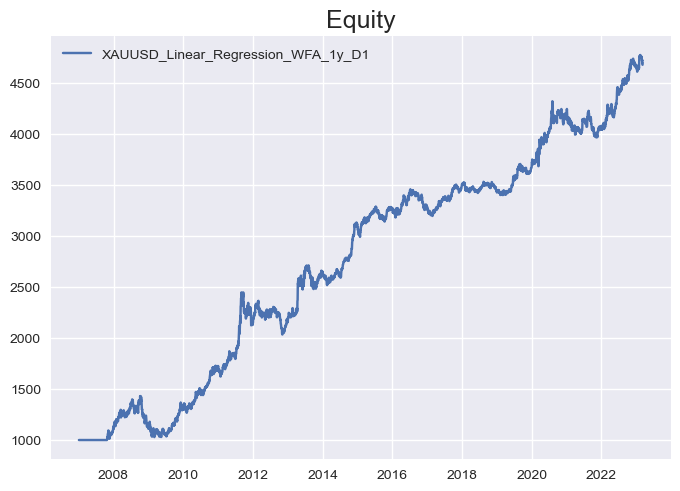

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_1y_D1_trade.csv


### Window size 2 year

In [43]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [44]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [45]:
test = ml.Run()

In [46]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   89.980159
Equity Final [$]                     4812.179
Equity Peak [$]                      4895.409
Return [%]                           381.2179
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                    8.172555
Volatility (Ann.) [%]               10.129958
Sharpe Ratio                         0.806771
Sortino Ratio                        1.314919
Calmar Ratio                         0.296151
Max. Drawdown [%]                  -27.595938
Avg. Drawdown [%]                   -1.554287
Max. Drawdown Duration      589 days 00:00:00
Avg. Drawdown Duration       33 days 00:00:00
# Trades                                 1036
Win Rate [%]                        53.378378
Best Trade [%]                      19.432916
Worst Trade [%]                     -9.384876
Avg. Trade [%]                    

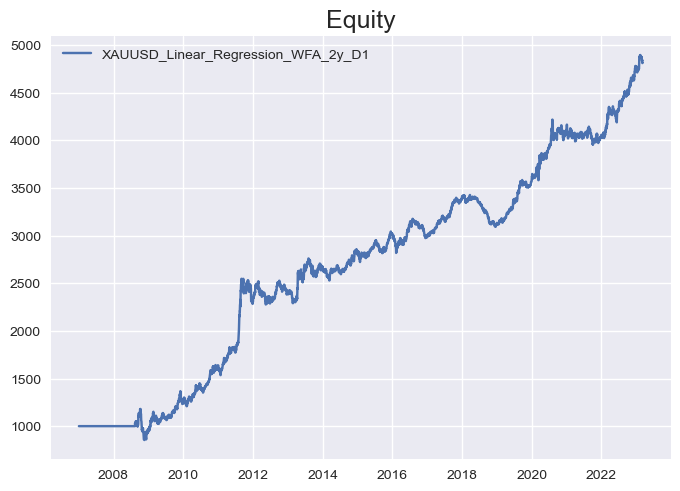

In [47]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [48]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [49]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_2y_D1_trade.csv


### Window size 3 year

In [50]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [51]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [52]:
test = ml.Run()

In [53]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   84.980159
Equity Final [$]                     2558.412
Equity Peak [$]                      2846.809
Return [%]                           155.8412
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                    4.808987
Volatility (Ann.) [%]                10.31617
Sharpe Ratio                          0.46616
Sortino Ratio                        0.702124
Calmar Ratio                         0.224984
Max. Drawdown [%]                  -21.374809
Avg. Drawdown [%]                   -2.614142
Max. Drawdown Duration      945 days 00:00:00
Avg. Drawdown Duration       57 days 00:00:00
# Trades                                  939
Win Rate [%]                        49.733759
Best Trade [%]                      57.122054
Worst Trade [%]                     -8.407325
Avg. Trade [%]                    

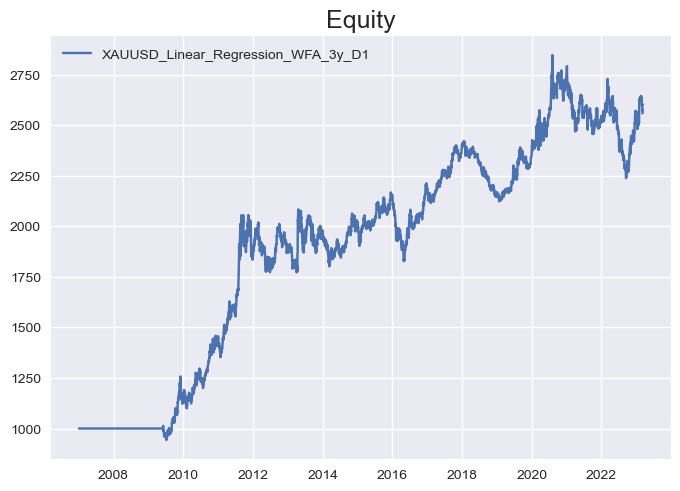

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [55]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [56]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_3y_D1_trade.csv


### Window size 4 year

In [57]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [58]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [59]:
test = ml.Run()

In [60]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   79.980159
Equity Final [$]                     1660.899
Equity Peak [$]                      1924.396
Return [%]                            66.0899
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                    2.569246
Volatility (Ann.) [%]               13.850572
Sharpe Ratio                         0.185497
Sortino Ratio                        0.270927
Calmar Ratio                         0.052559
Max. Drawdown [%]                  -48.882656
Avg. Drawdown [%]                   -3.885125
Max. Drawdown Duration     3836 days 00:00:00
Avg. Drawdown Duration      127 days 00:00:00
# Trades                                  793
Win Rate [%]                        46.532156
Best Trade [%]                      67.854486
Worst Trade [%]                    -12.649593
Avg. Trade [%]                    

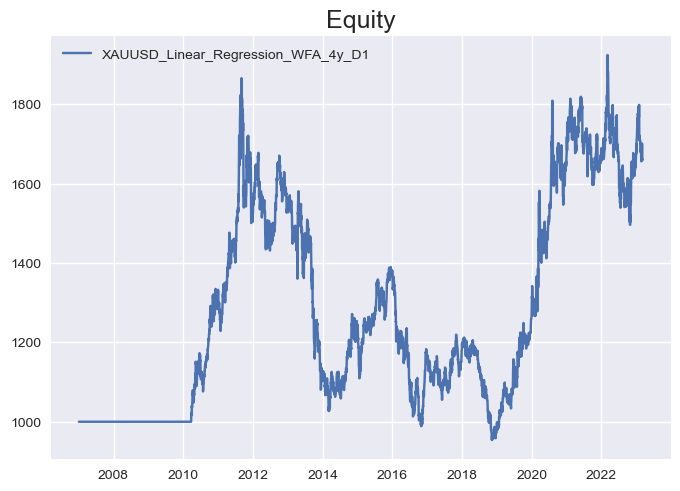

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [62]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [63]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_4y_D1_trade.csv


### Window size 5 year

In [64]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [65]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [66]:
test = ml.Run()

In [67]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   74.980159
Equity Final [$]                     2182.026
Equity Peak [$]                      2400.845
Return [%]                           118.2026
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                    3.978368
Volatility (Ann.) [%]               12.955883
Sharpe Ratio                          0.30707
Sortino Ratio                        0.465359
Calmar Ratio                         0.141911
Max. Drawdown [%]                  -28.034232
Avg. Drawdown [%]                   -3.626462
Max. Drawdown Duration     1537 days 00:00:00
Avg. Drawdown Duration       96 days 00:00:00
# Trades                                  645
Win Rate [%]                        50.387597
Best Trade [%]                       9.290183
Worst Trade [%]                     -6.449294
Avg. Trade [%]                    

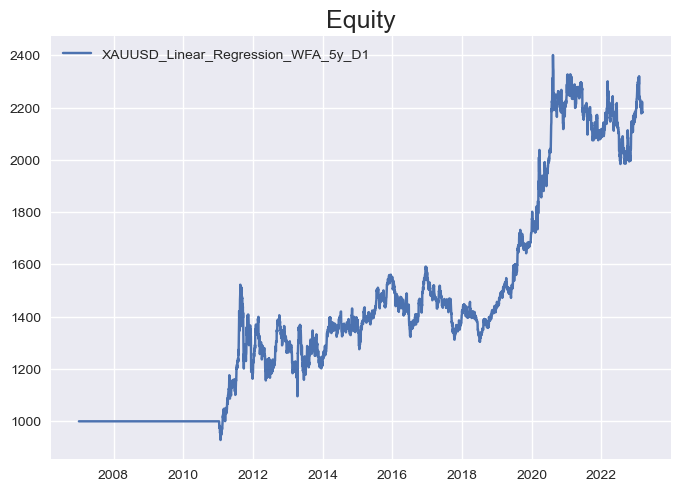

In [68]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [69]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [70]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_5y_D1_trade.csv


### Window size 6 year

In [71]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [72]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [73]:
test = ml.Run()

In [74]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   69.980159
Equity Final [$]                     1583.299
Equity Peak [$]                      1851.084
Return [%]                            58.3299
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                     2.32415
Volatility (Ann.) [%]               17.992005
Sharpe Ratio                         0.129177
Sortino Ratio                        0.193144
Calmar Ratio                         0.057062
Max. Drawdown [%]                  -40.730101
Avg. Drawdown [%]                   -6.386417
Max. Drawdown Duration     2822 days 00:00:00
Avg. Drawdown Duration      172 days 00:00:00
# Trades                                  547
Win Rate [%]                        52.650823
Best Trade [%]                      12.064133
Worst Trade [%]                    -14.148727
Avg. Trade [%]                    

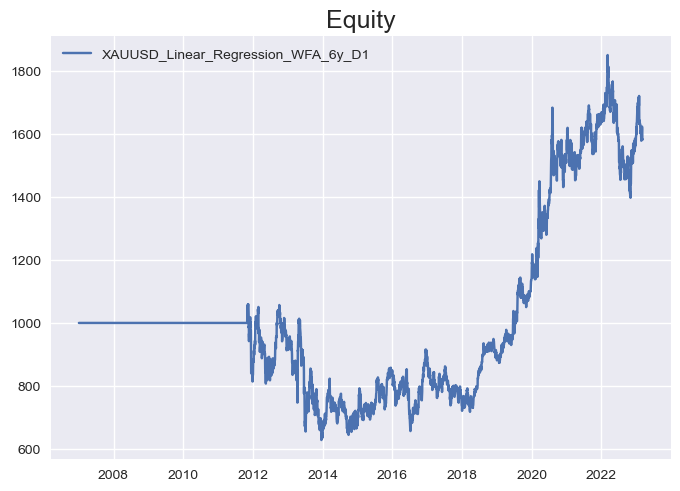

In [75]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [76]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [77]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_6y_D1_trade.csv


### Window size 7 year

In [78]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [79]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [80]:
test = ml.Run()

In [81]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   64.980159
Equity Final [$]                      984.248
Equity Peak [$]                      1671.539
Return [%]                            -1.5752
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                   -0.079355
Volatility (Ann.) [%]                18.49996
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -56.128847
Avg. Drawdown [%]                   -7.259767
Max. Drawdown Duration     2651 days 00:00:00
Avg. Drawdown Duration      182 days 00:00:00
# Trades                                  583
Win Rate [%]                         49.22813
Best Trade [%]                      12.064133
Worst Trade [%]                    -11.876942
Avg. Trade [%]                    

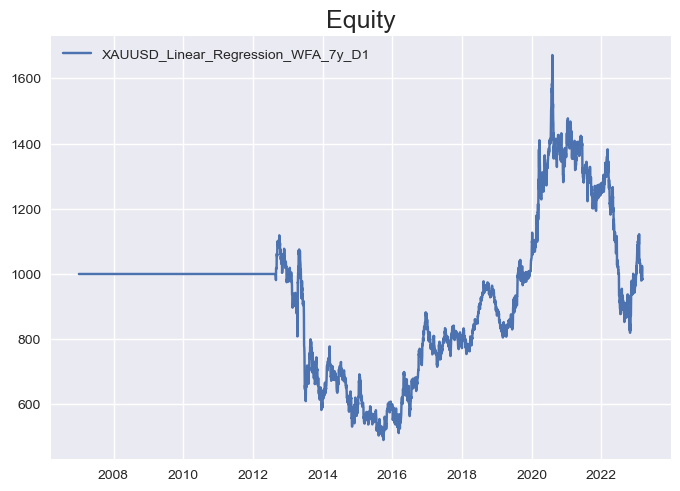

In [82]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [83]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [84]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_7y_D1_trade.csv


### Window size 8 year

In [85]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [86]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [87]:
test = ml.Run()

In [88]:
test

Start                     2007-01-03 00:00:00
End                       2023-03-09 00:00:00
Duration                   5909 days 00:00:00
Exposure Time [%]                   59.980159
Equity Final [$]                      955.073
Equity Peak [$]                      1324.616
Return [%]                            -4.4927
Buy & Hold Return [%]              192.277235
Return (Ann.) [%]                   -0.229574
Volatility (Ann.) [%]               16.596243
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -46.9094
Avg. Drawdown [%]                   -6.443846
Max. Drawdown Duration     1738 days 00:00:00
Avg. Drawdown Duration      154 days 00:00:00
# Trades                                  628
Win Rate [%]                        49.840764
Best Trade [%]                      12.064133
Worst Trade [%]                    -11.789874
Avg. Trade [%]                    

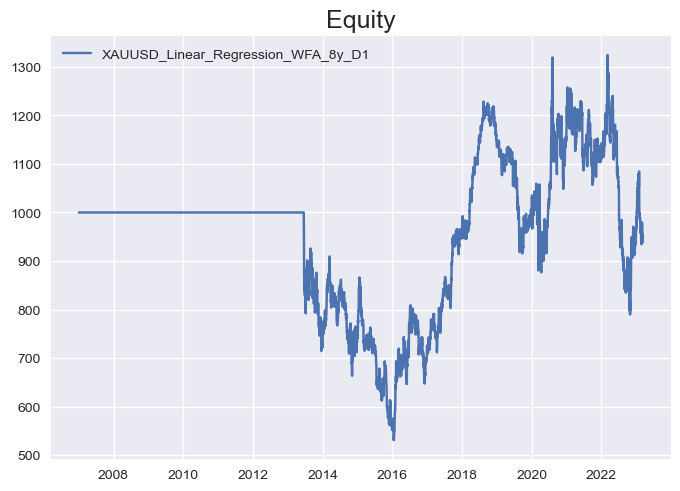

In [89]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [90]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [91]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_8y_D1_trade.csv


## TF H4

In [16]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H4'

### Window size 1 year

In [93]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [94]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [95]:
test = ml.Run()

In [96]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    94.17472
Equity Final [$]                      4899.43
Equity Peak [$]                        4926.5
Return [%]                            389.943
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                    8.264668
Volatility (Ann.) [%]               10.121983
Sharpe Ratio                         0.816507
Sortino Ratio                        1.321639
Calmar Ratio                         0.443582
Max. Drawdown [%]                  -18.631669
Avg. Drawdown [%]                   -0.927644
Max. Drawdown Duration      877 days 08:00:00
Avg. Drawdown Duration       13 days 08:00:00
# Trades                                 5960
Win Rate [%]                        53.104027
Best Trade [%]                      13.871314
Worst Trade [%]                    -12.413029
Avg. Trade [%]                    

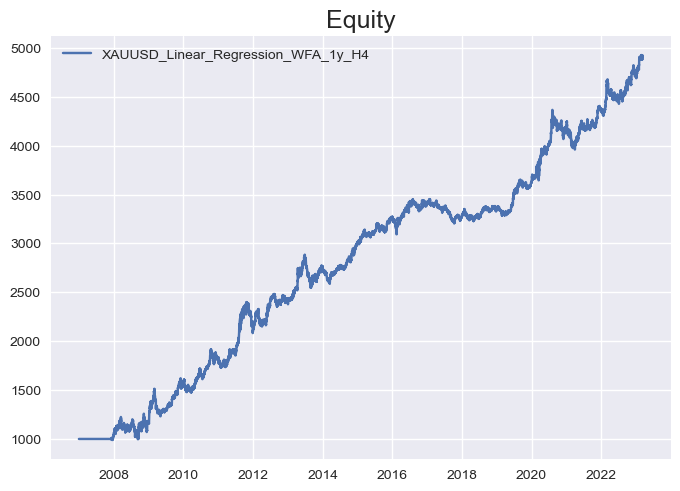

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [98]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [99]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_1y_H4_trade.csv


### Window size 2 year

In [100]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [101]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [102]:
test = ml.Run()

In [103]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    88.35329
Equity Final [$]                     3414.166
Equity Peak [$]                       3589.15
Return [%]                           241.4166
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                    6.328177
Volatility (Ann.) [%]               10.375984
Sharpe Ratio                         0.609887
Sortino Ratio                        0.953748
Calmar Ratio                         0.291064
Max. Drawdown [%]                  -21.741509
Avg. Drawdown [%]                   -1.092177
Max. Drawdown Duration      895 days 16:00:00
Avg. Drawdown Duration       17 days 17:00:00
# Trades                                 4641
Win Rate [%]                        53.156647
Best Trade [%]                      12.034657
Worst Trade [%]                    -12.120066
Avg. Trade [%]                    

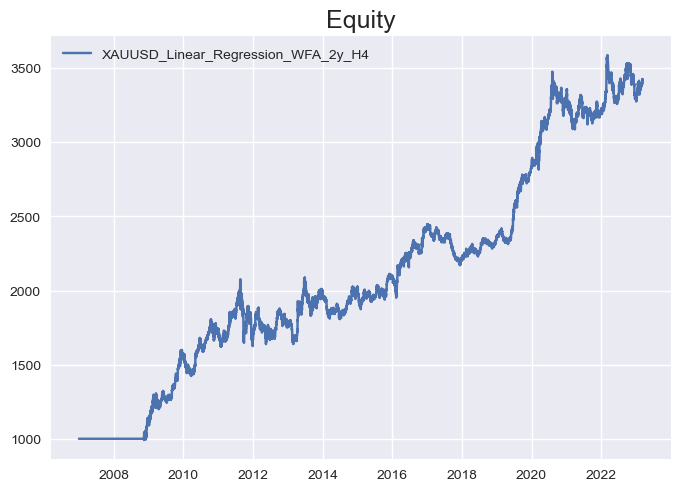

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [105]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [106]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_2y_H4_trade.csv


### Window size 3 year

In [107]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [108]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [109]:
test = ml.Run()

In [110]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    82.53186
Equity Final [$]                      2655.43
Equity Peak [$]                      2902.942
Return [%]                            165.543
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                    5.001167
Volatility (Ann.) [%]                 12.2003
Sharpe Ratio                         0.409922
Sortino Ratio                        0.618181
Calmar Ratio                         0.159402
Max. Drawdown [%]                  -31.374531
Avg. Drawdown [%]                   -1.227388
Max. Drawdown Duration     1647 days 20:00:00
Avg. Drawdown Duration       21 days 22:00:00
# Trades                                 4455
Win Rate [%]                        52.570146
Best Trade [%]                      10.366094
Worst Trade [%]                    -13.712238
Avg. Trade [%]                    

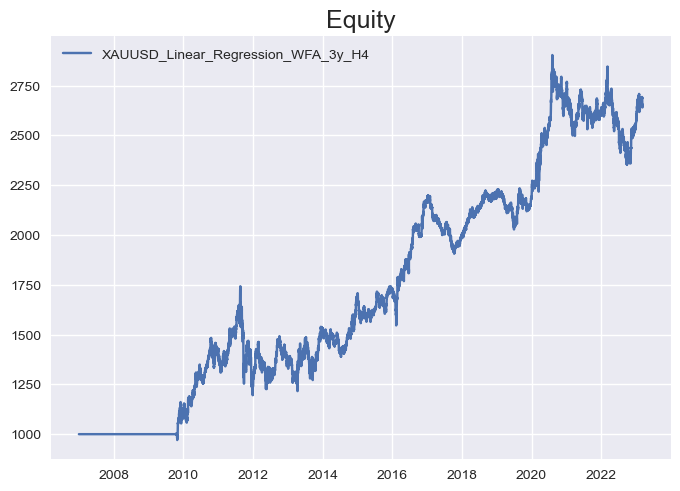

In [111]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [112]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [113]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_3y_H4_trade.csv


### Window size 4 year

In [114]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [115]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [116]:
test = ml.Run()

In [117]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    76.71043
Equity Final [$]                     1392.988
Equity Peak [$]                       1676.71
Return [%]                            39.2988
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                    1.670062
Volatility (Ann.) [%]                22.71603
Sharpe Ratio                         0.073519
Sortino Ratio                        0.106363
Calmar Ratio                         0.022423
Max. Drawdown [%]                  -74.480011
Avg. Drawdown [%]                   -2.284827
Max. Drawdown Duration     3235 days 16:00:00
Avg. Drawdown Duration       57 days 07:00:00
# Trades                                 4159
Win Rate [%]                        51.791296
Best Trade [%]                       8.928242
Worst Trade [%]                    -16.813661
Avg. Trade [%]                    

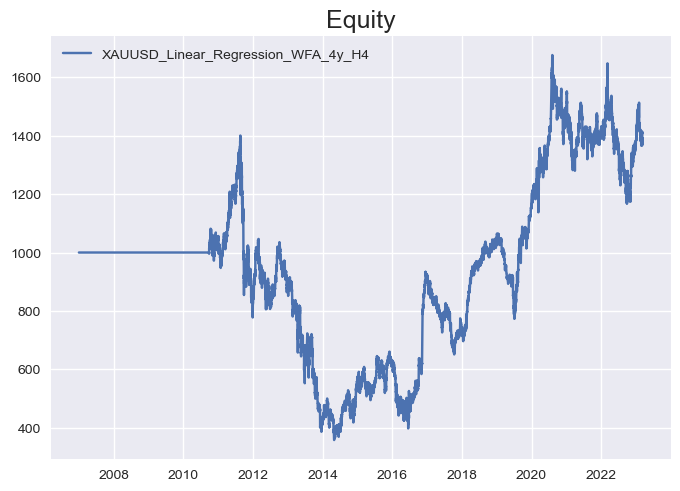

In [118]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [119]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [120]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_4y_H4_trade.csv


### Window size 5 year

In [17]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [18]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [19]:
test = ml.Run()

In [20]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    1.971278
Equity Final [$]                          0.0
Equity Peak [$]                       509.954
Return [%]                             -100.0
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              114.514389
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -50.586854
Max. Drawdown Duration     4204 days 08:00:00
Avg. Drawdown Duration     2102 days 08:00:00
# Trades                                   37
Win Rate [%]                        35.135135
Best Trade [%]                       2.824339
Worst Trade [%]                     -11.87869
Avg. Trade [%]                    

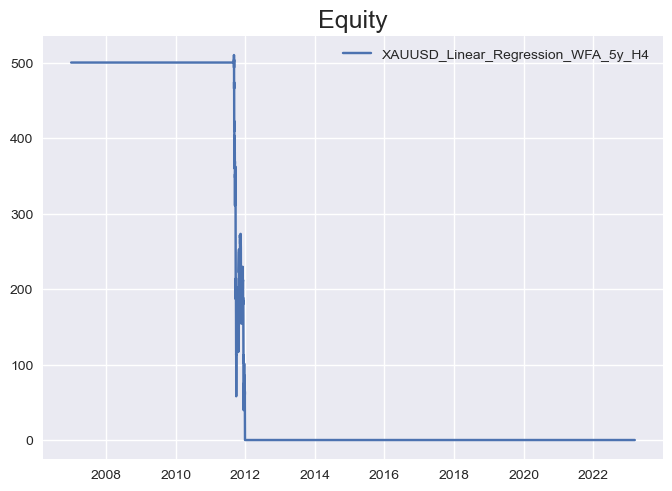

In [21]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [22]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [23]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [128]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [129]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [130]:
test = ml.Run()

In [131]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    65.06757
Equity Final [$]                      1338.53
Equity Peak [$]                       1608.54
Return [%]                             33.853
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                    1.467659
Volatility (Ann.) [%]               19.575605
Sharpe Ratio                         0.074974
Sortino Ratio                        0.107624
Calmar Ratio                          0.02485
Max. Drawdown [%]                  -59.060706
Avg. Drawdown [%]                    -3.43204
Max. Drawdown Duration     2860 days 12:00:00
Avg. Drawdown Duration       67 days 13:00:00
# Trades                                 3219
Win Rate [%]                        53.712333
Best Trade [%]                       6.497606
Worst Trade [%]                    -12.579104
Avg. Trade [%]                    

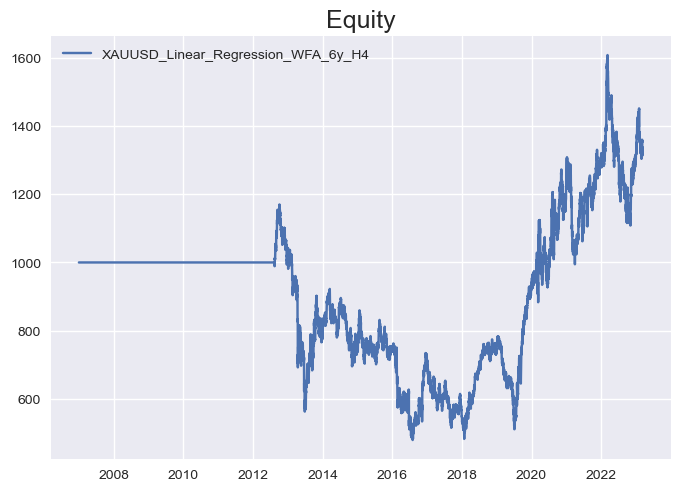

In [132]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [133]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [134]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_6y_H4_trade.csv


### Window size 7 year

In [135]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [136]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [137]:
test = ml.Run()

In [138]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    59.24614
Equity Final [$]                      1513.95
Equity Peak [$]                      1721.292
Return [%]                             51.395
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                       2.094
Volatility (Ann.) [%]                12.76438
Sharpe Ratio                          0.16405
Sortino Ratio                        0.243422
Calmar Ratio                         0.064617
Max. Drawdown [%]                  -32.406413
Avg. Drawdown [%]                   -2.287051
Max. Drawdown Duration     1288 days 04:00:00
Avg. Drawdown Duration       43 days 18:00:00
# Trades                                 3153
Win Rate [%]                         55.09039
Best Trade [%]                        5.73108
Worst Trade [%]                    -10.020197
Avg. Trade [%]                    

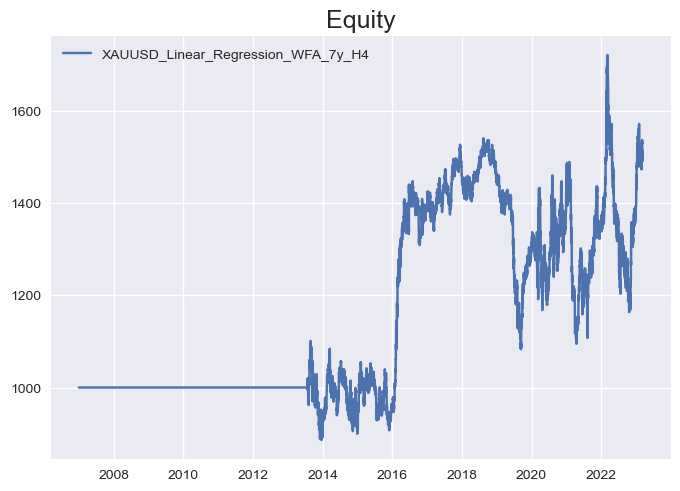

In [139]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [140]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [141]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_7y_H4_trade.csv


### Window size 8 year

In [142]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [143]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [144]:
test = ml.Run()

In [145]:
test

Start                     2007-01-01 08:00:00
End                       2023-03-10 12:00:00
Duration                   5912 days 04:00:00
Exposure Time [%]                    53.42471
Equity Final [$]                      791.131
Equity Peak [$]                      1265.439
Return [%]                           -20.8869
Buy & Hold Return [%]              192.923821
Return (Ann.) [%]                   -1.163935
Volatility (Ann.) [%]               16.120862
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -52.263839
Avg. Drawdown [%]                   -3.069611
Max. Drawdown Duration     2411 days 04:00:00
Avg. Drawdown Duration       83 days 04:00:00
# Trades                                 3473
Win Rate [%]                        53.095307
Best Trade [%]                       9.557412
Worst Trade [%]                    -10.376782
Avg. Trade [%]                    

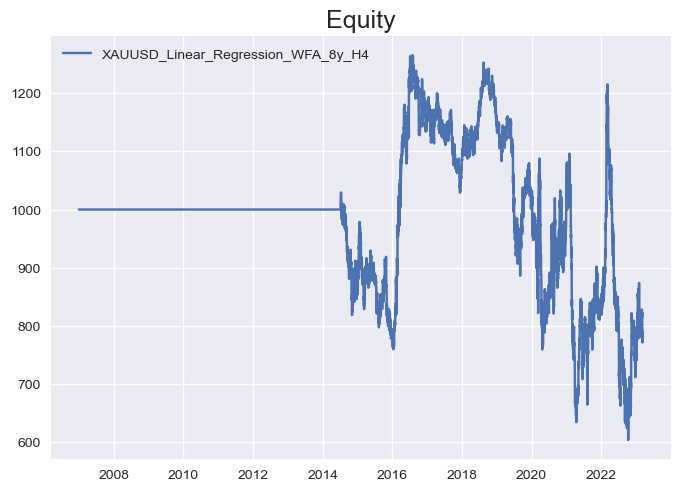

In [146]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [147]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [148]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_8y_H4_trade.csv


## TF H1

In [24]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H1'

### Window size 1 year

In [150]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [151]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [152]:
test = ml.Run()

In [153]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   93.824463
Equity Final [$]                     4757.648
Equity Peak [$]                      5016.259
Return [%]                           375.7648
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    8.105917
Volatility (Ann.) [%]                9.592007
Sharpe Ratio                          0.84507
Sortino Ratio                        1.367267
Calmar Ratio                         0.439572
Max. Drawdown [%]                  -18.440473
Avg. Drawdown [%]                   -0.619371
Max. Drawdown Duration      448 days 05:00:00
Avg. Drawdown Duration        7 days 07:00:00
# Trades                                22677
Win Rate [%]                        51.060546
Best Trade [%]                      14.520832
Worst Trade [%]                     -9.198473
Avg. Trade [%]                    

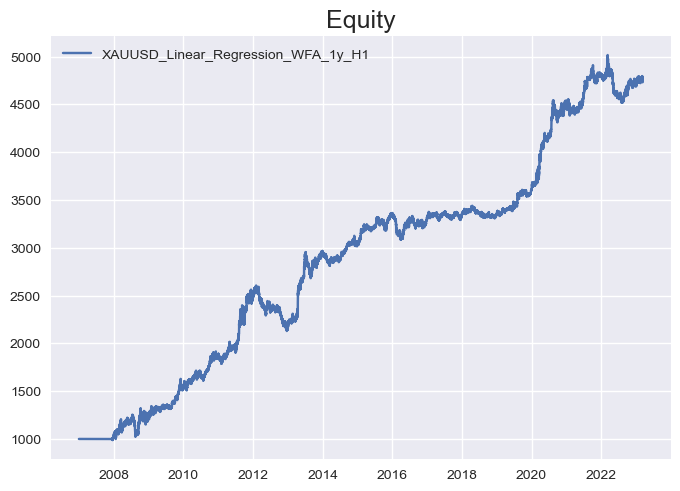

In [154]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [155]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [156]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

../../out/Machine_Learning/Linear Regression/Optimization/result_Linear_Regression_WFA_1y_H1_trade.csv


### Window size 2 year

In [25]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [26]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [27]:
test = ml.Run()

In [28]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   87.649947
Equity Final [$]                     4233.288
Equity Peak [$]                      4630.879
Return [%]                           323.3288
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                     7.47693
Volatility (Ann.) [%]                8.752195
Sharpe Ratio                         0.854292
Sortino Ratio                        1.365498
Calmar Ratio                         0.368465
Max. Drawdown [%]                  -20.292114
Avg. Drawdown [%]                   -0.583936
Max. Drawdown Duration     1263 days 12:00:00
Avg. Drawdown Duration        6 days 20:00:00
# Trades                                19591
Win Rate [%]                        51.518554
Best Trade [%]                      14.946863
Worst Trade [%]                     -8.812006
Avg. Trade [%]                    

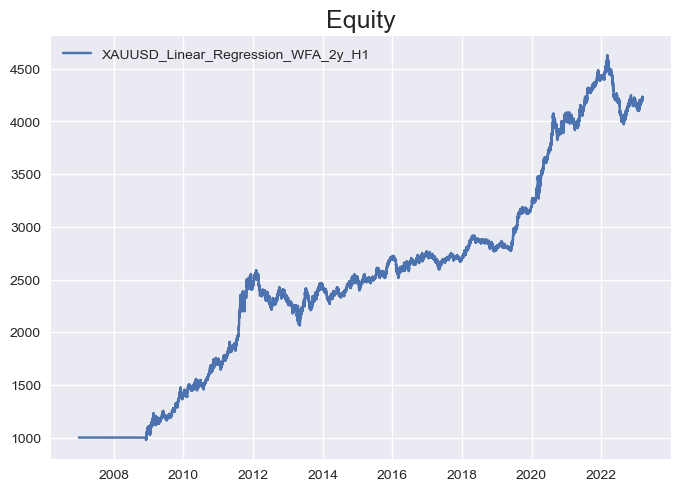

In [29]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [30]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [31]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [32]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [33]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [34]:
test = ml.Run()

In [35]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   81.475432
Equity Final [$]                     2593.574
Equity Peak [$]                      3077.773
Return [%]                           159.3574
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    4.877571
Volatility (Ann.) [%]               12.602538
Sharpe Ratio                         0.387031
Sortino Ratio                        0.573594
Calmar Ratio                         0.155383
Max. Drawdown [%]                   -31.39062
Avg. Drawdown [%]                   -0.890569
Max. Drawdown Duration     3090 days 13:00:00
Avg. Drawdown Duration       12 days 13:00:00
# Trades                                21291
Win Rate [%]                        51.143676
Best Trade [%]                       8.801823
Worst Trade [%]                     -7.065996
Avg. Trade [%]                    

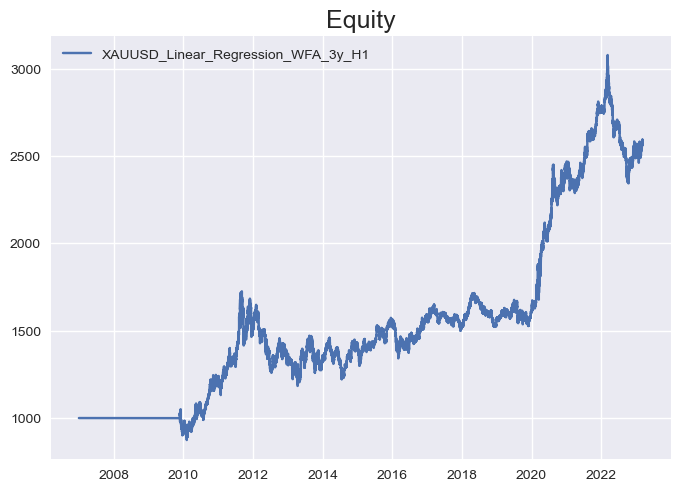

In [36]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [37]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [38]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [39]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [40]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [41]:
test = ml.Run()

In [42]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   75.300916
Equity Final [$]                     2009.236
Equity Peak [$]                      2553.303
Return [%]                           100.9236
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    3.548195
Volatility (Ann.) [%]               14.189915
Sharpe Ratio                          0.25005
Sortino Ratio                        0.360285
Calmar Ratio                          0.09133
Max. Drawdown [%]                   -38.85044
Avg. Drawdown [%]                   -1.153763
Max. Drawdown Duration     2992 days 07:00:00
Avg. Drawdown Duration       16 days 22:00:00
# Trades                                21615
Win Rate [%]                         51.54291
Best Trade [%]                       9.510329
Worst Trade [%]                     -7.152739
Avg. Trade [%]                    

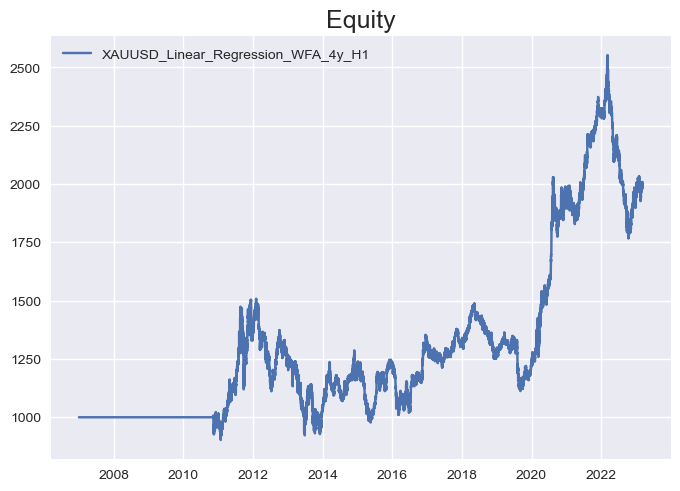

In [43]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [44]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [45]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [46]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [47]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [48]:
test = ml.Run()

In [49]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                     69.1264
Equity Final [$]                     1340.111
Equity Peak [$]                      1777.298
Return [%]                            34.0111
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    1.473644
Volatility (Ann.) [%]               28.813217
Sharpe Ratio                         0.051145
Sortino Ratio                        0.074487
Calmar Ratio                         0.019624
Max. Drawdown [%]                   -75.09577
Avg. Drawdown [%]                   -2.081264
Max. Drawdown Duration     3188 days 14:00:00
Avg. Drawdown Duration       29 days 00:00:00
# Trades                                20001
Win Rate [%]                          52.0024
Best Trade [%]                       3.579094
Worst Trade [%]                      -5.20936
Avg. Trade [%]                    

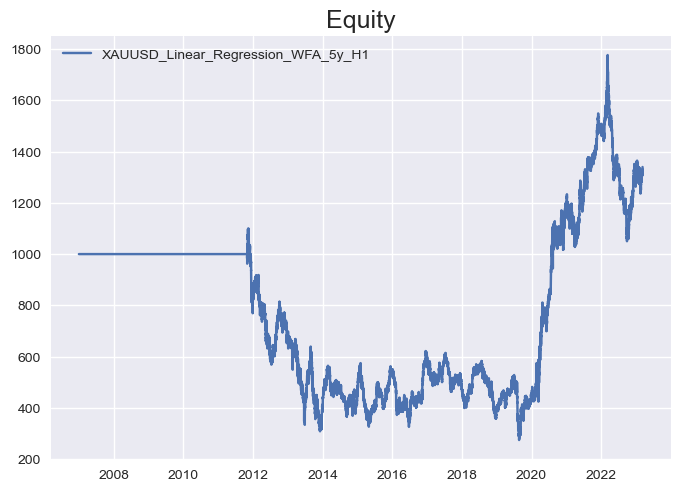

In [50]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [51]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [52]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [53]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [54]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [55]:
test = ml.Run()

In [56]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   62.951884
Equity Final [$]                     1723.593
Equity Peak [$]                      1945.577
Return [%]                            72.3593
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    2.757778
Volatility (Ann.) [%]               18.912575
Sharpe Ratio                         0.145817
Sortino Ratio                        0.212913
Calmar Ratio                         0.051365
Max. Drawdown [%]                  -53.689887
Avg. Drawdown [%]                   -1.706518
Max. Drawdown Duration     2796 days 23:00:00
Avg. Drawdown Duration       27 days 19:00:00
# Trades                                17485
Win Rate [%]                        52.078925
Best Trade [%]                      13.841387
Worst Trade [%]                     -6.054002
Avg. Trade [%]                    

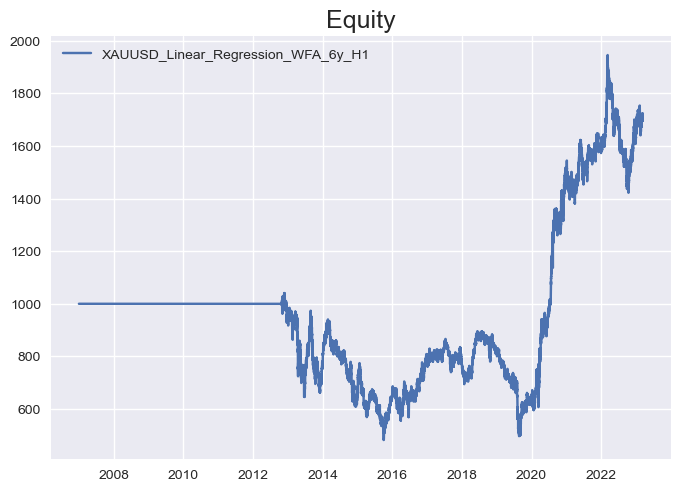

In [57]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [58]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [59]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [60]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [61]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [62]:
test = ml.Run()

In [63]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   56.777368
Equity Final [$]                     1789.424
Equity Peak [$]                      1875.516
Return [%]                            78.9424
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    2.950426
Volatility (Ann.) [%]               16.256698
Sharpe Ratio                          0.18149
Sortino Ratio                        0.269449
Calmar Ratio                         0.060587
Max. Drawdown [%]                  -48.697023
Avg. Drawdown [%]                    -1.60917
Max. Drawdown Duration     1504 days 22:00:00
Avg. Drawdown Duration       21 days 02:00:00
# Trades                                16829
Win Rate [%]                        51.850972
Best Trade [%]                       3.292779
Worst Trade [%]                     -5.251277
Avg. Trade [%]                    

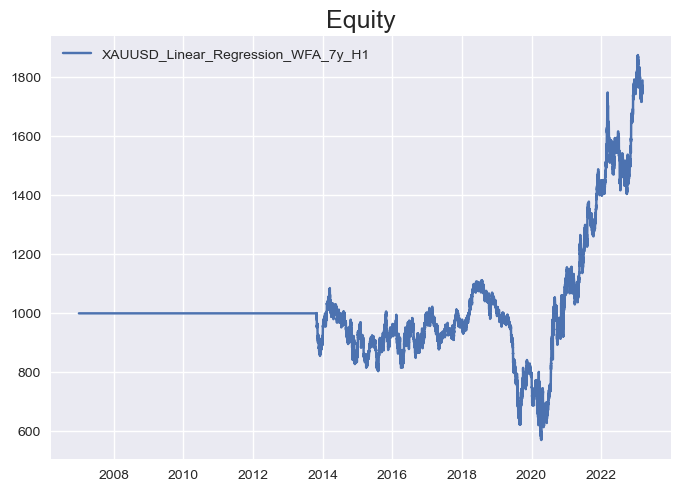

In [64]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [65]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [66]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [67]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [68]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [69]:
test = ml.Run()

In [70]:
test

Start                     2007-01-01 02:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   50.602852
Equity Final [$]                     1660.775
Equity Peak [$]                      1871.063
Return [%]                            66.0775
Buy & Hold Return [%]              191.659658
Return (Ann.) [%]                    2.567315
Volatility (Ann.) [%]               13.895968
Sharpe Ratio                         0.184753
Sortino Ratio                        0.271073
Calmar Ratio                         0.066256
Max. Drawdown [%]                   -38.74831
Avg. Drawdown [%]                   -1.772906
Max. Drawdown Duration      817 days 03:00:00
Avg. Drawdown Duration       17 days 01:00:00
# Trades                                17134
Win Rate [%]                        51.499942
Best Trade [%]                       3.319807
Worst Trade [%]                     -5.465692
Avg. Trade [%]                    

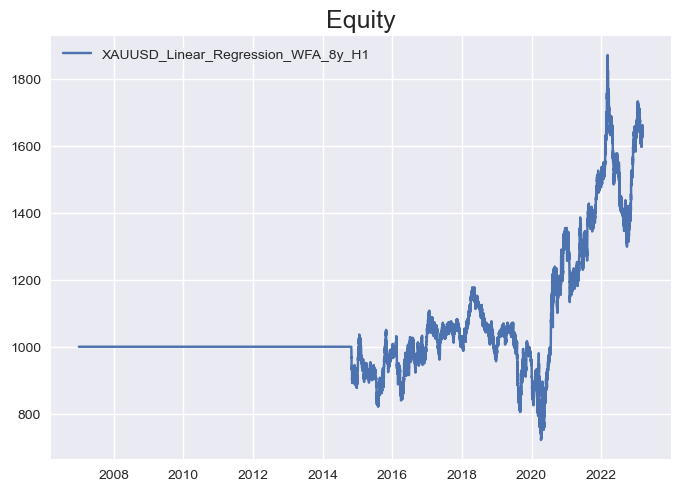

In [71]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [72]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [73]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [77]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H30'

### Window size 1 year

In [79]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [80]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [81]:
test = ml.Run()

In [82]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   93.803846
Equity Final [$]                     4065.834
Equity Peak [$]                      4536.773
Return [%]                           306.5834
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    7.260388
Volatility (Ann.) [%]                9.712781
Sharpe Ratio                         0.747509
Sortino Ratio                        1.211647
Calmar Ratio                         0.301248
Max. Drawdown [%]                  -24.101071
Avg. Drawdown [%]                   -0.486226
Max. Drawdown Duration      962 days 02:30:00
Avg. Drawdown Duration        5 days 09:53:00
# Trades                                46911
Win Rate [%]                        50.823901
Best Trade [%]                      25.708837
Worst Trade [%]                     -8.712892
Avg. Trade [%]                    

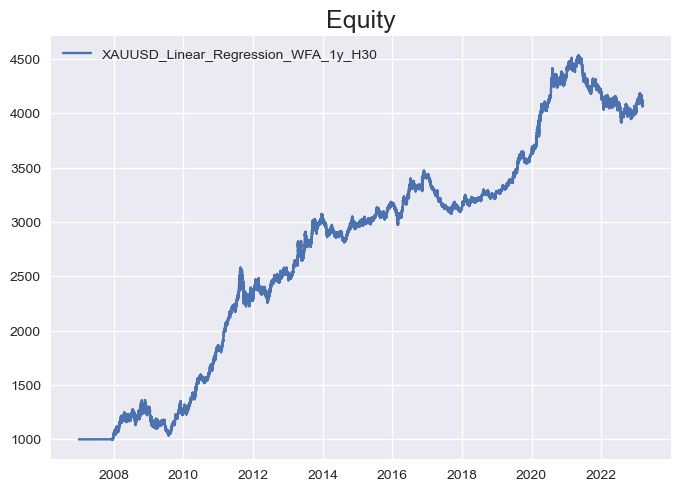

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [84]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [85]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [86]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [87]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [88]:
test = ml.Run()

In [89]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   87.608203
Equity Final [$]                     3583.581
Equity Peak [$]                      3866.192
Return [%]                           258.3581
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    6.585806
Volatility (Ann.) [%]               10.405987
Sharpe Ratio                         0.632886
Sortino Ratio                        0.997117
Calmar Ratio                         0.277432
Max. Drawdown [%]                  -23.738489
Avg. Drawdown [%]                   -0.516004
Max. Drawdown Duration      627 days 16:00:00
Avg. Drawdown Duration        6 days 09:24:00
# Trades                                35991
Win Rate [%]                        50.573755
Best Trade [%]                      19.299221
Worst Trade [%]                     -6.414788
Avg. Trade [%]                    

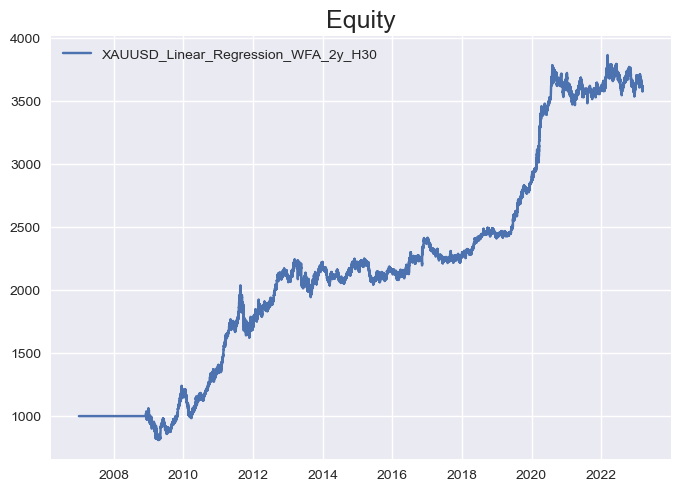

In [90]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [91]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [92]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [93]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [94]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [95]:
test = ml.Run()

In [96]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   81.412561
Equity Final [$]                     2729.285
Equity Peak [$]                      2862.222
Return [%]                           172.9285
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    5.145206
Volatility (Ann.) [%]                10.10606
Sharpe Ratio                         0.509121
Sortino Ratio                        0.782334
Calmar Ratio                         0.231554
Max. Drawdown [%]                  -22.220303
Avg. Drawdown [%]                   -0.708453
Max. Drawdown Duration     2532 days 19:30:00
Avg. Drawdown Duration       10 days 07:56:00
# Trades                                33117
Win Rate [%]                        49.986412
Best Trade [%]                      23.796404
Worst Trade [%]                     -4.826401
Avg. Trade [%]                    

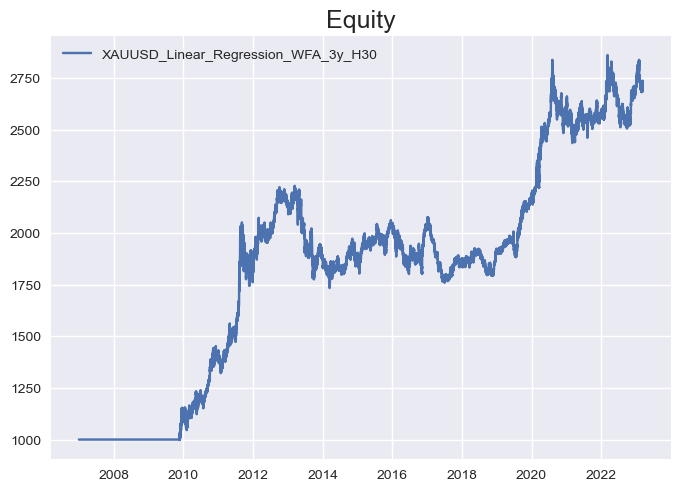

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [98]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [99]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [100]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [101]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [102]:
test = ml.Run()

In [103]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   75.216919
Equity Final [$]                     2200.313
Equity Peak [$]                      2310.268
Return [%]                           120.0313
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    4.019326
Volatility (Ann.) [%]               13.121188
Sharpe Ratio                         0.306323
Sortino Ratio                        0.446442
Calmar Ratio                         0.106078
Max. Drawdown [%]                  -37.890221
Avg. Drawdown [%]                   -1.185953
Max. Drawdown Duration     1412 days 22:30:00
Avg. Drawdown Duration       15 days 00:57:00
# Trades                                29891
Win Rate [%]                        49.723997
Best Trade [%]                      25.102915
Worst Trade [%]                    -19.264098
Avg. Trade [%]                    

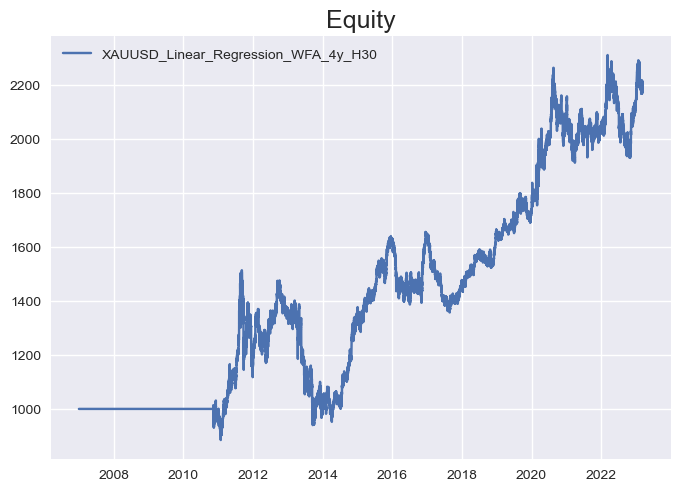

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [105]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [106]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [107]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [108]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [109]:
test = ml.Run()

In [110]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   69.021277
Equity Final [$]                      1738.05
Equity Peak [$]                      1874.609
Return [%]                             73.805
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    2.800677
Volatility (Ann.) [%]               18.207019
Sharpe Ratio                         0.153824
Sortino Ratio                        0.225164
Calmar Ratio                         0.048946
Max. Drawdown [%]                  -57.219984
Avg. Drawdown [%]                   -1.954379
Max. Drawdown Duration     1479 days 21:30:00
Avg. Drawdown Duration       27 days 19:46:00
# Trades                                28085
Win Rate [%]                        49.784583
Best Trade [%]                       6.737506
Worst Trade [%]                     -9.810541
Avg. Trade [%]                    

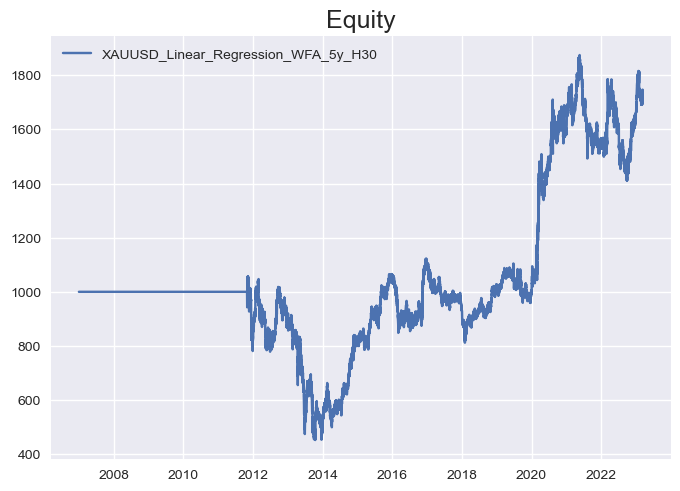

In [111]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [112]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [113]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [114]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [115]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [116]:
test = ml.Run()

In [117]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   62.825635
Equity Final [$]                     1659.586
Equity Peak [$]                      1754.476
Return [%]                            65.9586
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    2.563644
Volatility (Ann.) [%]               17.731503
Sharpe Ratio                         0.144581
Sortino Ratio                        0.206337
Calmar Ratio                         0.053404
Max. Drawdown [%]                   -48.00447
Avg. Drawdown [%]                   -1.935866
Max. Drawdown Duration     2658 days 21:00:00
Avg. Drawdown Duration       28 days 04:33:00
# Trades                                20971
Win Rate [%]                        50.460159
Best Trade [%]                       6.943857
Worst Trade [%]                     -7.679804
Avg. Trade [%]                    

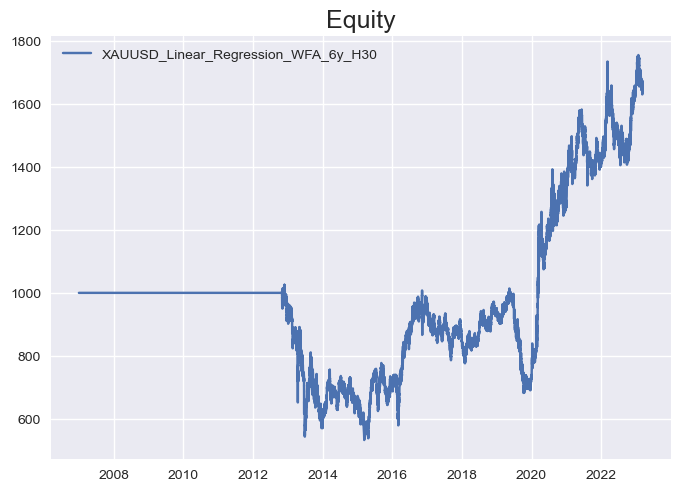

In [118]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [119]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [120]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [121]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [122]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [123]:
test = ml.Run()

In [124]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   56.629993
Equity Final [$]                      889.934
Equity Peak [$]                      1287.515
Return [%]                           -11.0066
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                   -0.580999
Volatility (Ann.) [%]               15.915411
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -50.908688
Avg. Drawdown [%]                   -1.135472
Max. Drawdown Duration     1667 days 16:00:00
Avg. Drawdown Duration       25 days 10:33:00
# Trades                                21800
Win Rate [%]                        50.261468
Best Trade [%]                      10.432804
Worst Trade [%]                    -11.008967
Avg. Trade [%]                    

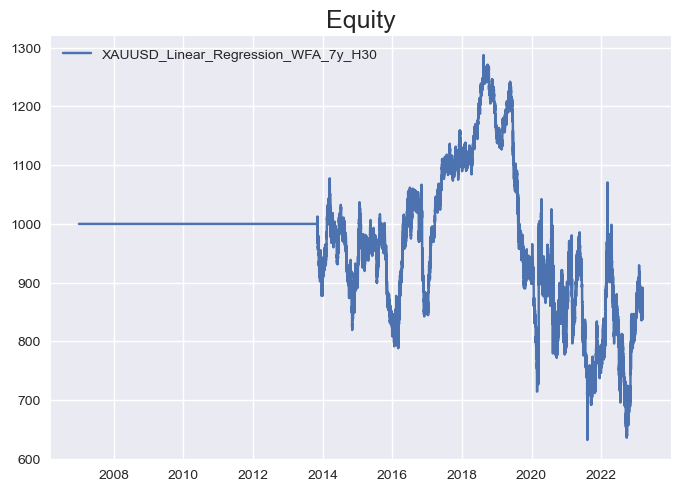

In [125]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [126]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [127]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [128]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [129]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [130]:
test = ml.Run()

In [131]:
test

Start                     2007-01-01 01:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   50.434351
Equity Final [$]                     1443.136
Equity Peak [$]                      1515.818
Return [%]                            44.3136
Buy & Hold Return [%]              192.927151
Return (Ann.) [%]                    1.849904
Volatility (Ann.) [%]               12.686856
Sharpe Ratio                         0.145813
Sortino Ratio                        0.226624
Calmar Ratio                         0.067508
Max. Drawdown [%]                  -27.402705
Avg. Drawdown [%]                   -2.145064
Max. Drawdown Duration      769 days 15:30:00
Avg. Drawdown Duration       28 days 22:04:00
# Trades                                19546
Win Rate [%]                        51.094853
Best Trade [%]                       7.762056
Worst Trade [%]                    -15.045329
Avg. Trade [%]                    

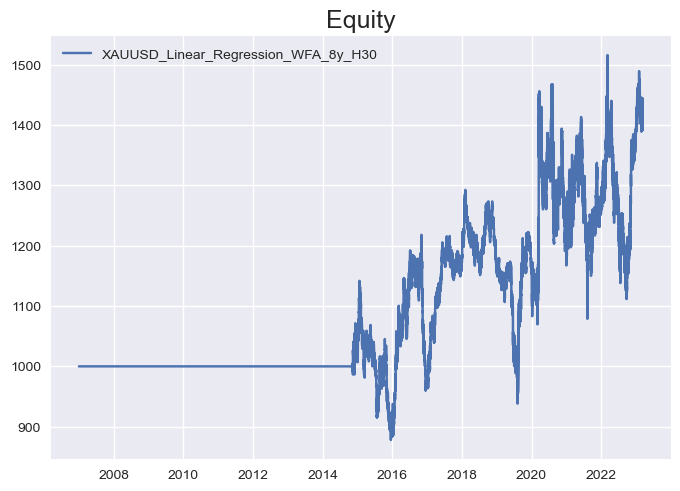

In [132]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [133]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [134]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')